# Data Generation Example

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from tqdm import tqdm
sys.path.append("../")

from data_loader import CityScapesNumpy, COCO_INSTANCE_CATEGORY_NAMES
from tracking.tracking_utils import iou_2d
from scipy.optimize import linear_sum_assignment

# ...

In [2]:
_COLORS = list(mcolors.CSS4_COLORS)
ASSIGNMENT_THRESH = 0.0
OTHER_CATEGORIES = objects = [2, 4, 6, 7, 8,  10, 13, 18]

In [24]:
def plot_detections(ax, boxes, labels, scores, categories, ids=None, score_thresh=0.5):
    """"""

    for i, _ in enumerate(scores):
        if scores[i] > score_thresh and labels[i] in categories:
            x1, y1, x2, y2 = boxes[i]

            if ids is not None:
                string = str(COCO_INSTANCE_CATEGORY_NAMES[labels[i]]) + " " + str(ids[i]) + ", score: " + "{:.3f}".format(scores[i])
                col_idx = ids[i]  if ids[i] < len(_COLORS) else ids[i] % len(_COLORS)
                col = _COLORS[col_idx]
                if labels[i] == 3 and x1 < 1500:
                    ax.text(x1, y1-10, string, color=col, fontsize=4)
            else:
                col = "k"#_COLORS[labels[i]]

            ax.plot([x1, x1], [y1, y2], color=col)
            ax.plot([x2, x2], [y1, y2], color=col)
            ax.plot([x1, x2], [y1, y1], color=col)
            ax.plot([x2, x1], [y2, y2], color=col)

In [4]:
data_set = CityScapesNumpy(base_dir="D:\\Random\\Cityscapes\\final_segmented\\stuttgart_00\\")

In [5]:
class Tracker:
    def __init__(self, category, boxes, labels, scores):
        self.category = category
        
        category_mask = labels == self.category
        boxes, labels, scores = boxes[category_mask], labels[category_mask], scores[category_mask]
        
        self.known_ids = np.arange(len(labels))
        self.known_boxes = boxes
        self.cur_id = len(labels)
        
    def run(self, boxes, labels, scores):
        category_mask = labels == self.category
        boxes, labels, scores = boxes[category_mask], labels[category_mask], scores[category_mask]
        
        pair_cost = np.array([[iou_2d(bx1, bx2) for bx2 in boxes] for bx1 in self.known_boxes])
        pair_cost *= -1

        if pair_cost.shape[0] == 0:
            pairs = []

        else:

            row_ind, col_ind = linear_sum_assignment(pair_cost)

            pairs = [(row_ind[j], col_ind[j]) for j, _ in enumerate(row_ind) 
                         if  pair_cost[row_ind[j]][col_ind[j]] < ASSIGNMENT_THRESH]

        new_ids = [None] * len(labels)

        # print(len(known_ids), len(new_ids))
        # print("pairs:", pairs)

        # Update known detections
        for pair in pairs:
            old_idx, new_idx = pair
            new_ids[new_idx] = self.known_ids[old_idx]

        # Spawn unmatched dets
        for i, id in enumerate(new_ids):
            if id is None:
                new_ids[i] = self.cur_id
                self.cur_id += 1

        self.known_boxes = boxes
        self.known_ids = new_ids
        
        return new_ids, boxes, labels, scores     

100%|████████████████████████████████████████████████████████████████████████████████| 598/598 [10:02<00:00,  1.01s/it]


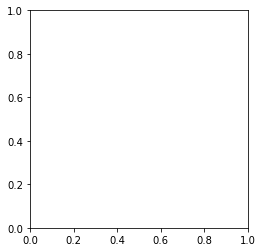

In [25]:
images = glob.glob("D:\\Random\\Cityscapes\\final_segmented\\stuttgart_00\\" + "\\*.png")
target_dir = "D:\Random\Cityscapes\seg+track\\"

img, boxes, lbls, scrs = data_set.get(images[0])
car_tracker = Tracker(3, boxes, lbls, scrs)
ped_tracker = Tracker(1, boxes, lbls, scrs)

fig, ax = plt.subplots()

for i in tqdm(range(1, len(images))):
    img_next, boxes_next, lbls_next, scrs_next = data_set.get(images[i])
    
    car_ids, car_boxes, car_labels, car_scores = car_tracker.run(boxes_next, lbls_next, scrs_next)
    ped_ids, ped_boxes, ped_labels, ped_scores = ped_tracker.run(boxes_next, lbls_next, scrs_next)
    
    car_mask = lbls_next == 3
    ped_mask = lbls_next == 1
    
    car_ped_mask = np.logical_and(car_mask, ped_mask)
    not_car_ped_mask = np.logical_not(car_ped_mask)
    
    
    other_boxes = boxes_next[not_car_ped_mask] 
    other_labels = lbls_next[not_car_ped_mask] 
    other_scores = scrs_next[not_car_ped_mask]
    

    ax.imshow(img_next)
    plot_detections(ax, other_boxes, other_labels, other_scores, OTHER_CATEGORIES)
    plot_detections(ax, car_boxes, car_labels, car_scores, [3], ids=car_ids)
    plot_detections(ax, ped_boxes, ped_labels, ped_scores, [1], ids=ped_ids)
    
    plt.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    plt.savefig(target_dir + str(i) + ".png",dpi=200, bbox_inches='tight')
    ax.clear()
    